In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split


In [ ]:
df = pd.read_csv('fake_news.csv')
print(df.head())

In [ ]:
df.isnull().sum()

In [ ]:
df.dropna(inplace=True)
print(df.head())

In [ ]:
# 1.EDA Expansion
# Separate fake and real headlines
fake_headlines = df[df['label'] == 'Fake']['headline']
real_headlines = df[df['label'] == 'Real']['headline']

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

# Preprocess the headlines
fake_text = ' '.join(fake_headlines.apply(preprocess_text))
real_text = ' '.join(real_headlines.apply(preprocess_text))

# Generate word clouds
fake_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
real_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(real_text)

# Plot the word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.title('Fake Headlines Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.title('Real Headlines Word Cloud')
plt.axis('off')

plt.show()

In [ ]:
#  2.Advanced Text Preprocessing
import nltk
from nltk.stem import WordNetLemmatizer

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text with lemmatization
def preprocess_text_with_lemmatization(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Preprocess the headlines with lemmatization
fake_text_lemmatized = ' '.join(fake_headlines.apply(preprocess_text_with_lemmatization))
real_text_lemmatized = ' '.join(real_headlines.apply(preprocess_text_with_lemmatization))

# Generate word clouds for lemmatized text
fake_wordcloud_lemmatized = WordCloud(width=800, height=400, background_color='white').generate(fake_text_lemmatized)
real_wordcloud_lemmatized = WordCloud(width=800, height=400, background_color='white').generate(real_text_lemmatized)

# Plot the word clouds for lemmatized text
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(fake_wordcloud_lemmatized, interpolation='bilinear')
plt.title('Fake Headlines Word Cloud (Lemmatized)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(real_wordcloud_lemmatized, interpolation='bilinear')
plt.title('Real Headlines Word Cloud (Lemmatized)')
plt.axis('off')

plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer


# 3. Class Imbalance Handling
real_headlines_undersampled = real_headlines.sample(len(fake_headlines), random_state=42)
balanced_df = pd.concat([fake_headlines, real_headlines_undersampled]).reset_index(drop=True)
print(f"Number of Fake headlines: {len(fake_headlines)}")
print(f"Number of Real headlines after undersampling: {len(real_headlines_undersampled)}")

# Converting the balanced_df Series to a DataFrame with labels
balanced_df = pd.DataFrame({'headline': balanced_df, 'label': ['Fake'] * len(fake_headlines) + ['Real'] * len(real_headlines_undersampled)})

# Vectorizing text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(balanced_df['headline'])
y = balanced_df['label']

# Applying SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(f"Original dataset size: {X.shape[0]}")
print(f"Resampled dataset size: {X_resampled.shape[0]}")

In [488]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

#4.Hyperparameter Tuning

 #Random Forest
#Parameter grid for RandomizedSearchCV
rf_random_param_grid = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

#RandomizedSearchCV with RandomForestClassifier
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_random_param_grid,
    n_iter=50,  # Number of parameter settings sampled
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Fitting RandomizedSearchCV on the resampled data
rf_random_search.fit(X_resampled, y_resampled)

print("Best Parameters:", rf_random_search.best_params_)
print("Best Score:", rf_random_search.best_score_)

#SVM
# Defining the parameter grid for GridSearchCV
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}







Best Parameters: {'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': True}
Best Score: 0.5666666666666667


In [489]:
#SVM model
svm_model = SVC(random_state=42)

#GridSearchCV
svm_grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=svm_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1
)

# Fit GridSearchCV on the resampled data
svm_grid_search.fit(X_resampled, y_resampled)

#The best parameters and best score
print("Best Parameters:", svm_grid_search.best_params_)
print("Best Score:", svm_grid_search.best_score_)

Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.4333333333333333


In [490]:
# Logistic Regression
# Defining the parameter grid for GridSearchCV
logistic_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support l1 and l2 penalties
}

# GridSearchCV with LogisticRegression
logistic_grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    param_grid=logistic_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1
)

# Fitting GridSearchCV on the resampled data
logistic_grid_search.fit(X_resampled, y_resampled)

print("Best Parameters:", logistic_grid_search.best_params_)
print("Best Score:", logistic_grid_search.best_score_)


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.5


In [491]:
#Which hyperparameters provide the best accuracy?
best_model = max(
    [('Random Forest', rf_random_search.best_score_),
     ('SVM', svm_grid_search.best_score_),
     ('Logistic Regression', logistic_grid_search.best_score_)],
    key=lambda x: x[1]
)

print(f"The model with the best accuracy is {best_model[0]} with a score of {best_model[1]:.4f}")

The model with the best accuracy is Random Forest with a score of 0.5667


In [492]:
from sklearn.model_selection import cross_val_score
import numpy as np

#5.Cross-Validation Evaluation
# K-Fold Cross-Validation (K=5)
k = 5

# Random Forest
rf_cv_scores = cross_val_score(rf_model, X_resampled, y_resampled, cv=k, scoring='accuracy')
print(f"Random Forest - Average Accuracy: {np.mean(rf_cv_scores):.4f}, Standard Deviation: {np.std(rf_cv_scores):.4f}")

# SVM
svm_cv_scores = cross_val_score(svm_model, X_resampled, y_resampled, cv=k, scoring='accuracy')
print(f"SVM - Average Accuracy: {np.mean(svm_cv_scores):.4f}, Standard Deviation: {np.std(svm_cv_scores):.4f}")

# Logistic Regression
logistic_cv_scores = cross_val_score(logistic_grid_search.best_estimator_, X_resampled, y_resampled, cv=k, scoring='accuracy')
print(f"Logistic Regression - Average Accuracy: {np.mean(logistic_cv_scores):.4f}, Standard Deviation: {np.std(logistic_cv_scores):.4f}")

Random Forest - Average Accuracy: 0.5667, Standard Deviation: 0.2494
SVM - Average Accuracy: 0.3667, Standard Deviation: 0.0667
Logistic Regression - Average Accuracy: 0.5000, Standard Deviation: 0.1491


In [493]:
from scipy.sparse import hstack

#6.Feature Engineering

#Custom features: headline length, number of capital letters, and punctuation count
balanced_df['headline_length'] = balanced_df['headline'].apply(len)
balanced_df['capital_letters'] = balanced_df['headline'].apply(lambda x: sum(1 for c in x if c.isupper()))
balanced_df['punctuation_count'] = balanced_df['headline'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

# Vectorizing text data with additional features
X_text = vectorizer.fit_transform(balanced_df['headline'])
X_custom_features = balanced_df[['headline_length', 'capital_letters', 'punctuation_count']].values
X_combined = hstack([X_text, X_custom_features])

# Splitting the data
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_combined, balanced_df['label'], test_size=0.2, random_state=42
)

# Training a Random Forest model with the new features
rf_model_with_features = RandomForestClassifier(random_state=42)
rf_model_with_features.fit(X_train_combined, y_train_combined)

# Evaluating the model
accuracy_with_features = rf_model_with_features.score(X_test_combined, y_test_combined)
print(f"Accuracy with custom features: {accuracy_with_features:.4f}")
# Display the feature importances for the custom features
feature_importances = rf_model_with_features.feature_importances_[-3:]  # Last 3 are custom features
custom_feature_names = ['headline_length', 'capital_letters', 'punctuation_count']

for name, importance in zip(custom_feature_names, feature_importances):
    print(f"Feature: {name}, Importance: {importance:.4f}")
    
    

Accuracy with custom features: 0.3333
Feature: headline_length, Importance: 0.1345
Feature: capital_letters, Importance: 0.0469
Feature: punctuation_count, Importance: 0.0078


In [494]:
# Displaying the first few rows of the balanced DataFrame with new features
print(balanced_df.head())

                                        headline label  headline_length  \
0    Aliens spotted near White House says report  Fake               43   
1       Man turns into lizard after vaccine shot  Fake               40   
2      New miracle diet pill melts fat overnight  Fake               41   
3  Time traveler reveals future events on TikTok  Fake               45   
4  Police uncover alien base beneath supermarket  Fake               45   

   capital_letters  punctuation_count  
0                3                  0  
1                1                  0  
2                1                  0  
3                3                  0  
4                1                  0  


Random Forest Performance:
              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00         3
        Real       0.40      1.00      0.57         2

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5

Accuracy: 0.4000


SVM Performance:
              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00         3
        Real       0.40      1.00      0.57         2

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5

Accuracy: 0.4000


Logistic Regression Performance:
              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00         3
        Real       0.40      1.00      0.57         2

    accuracy                           0.40         5
   macro avg 

c:\Users\CAPACITI-JHB\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CAPACITI-JHB\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CAPACITI-JHB\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

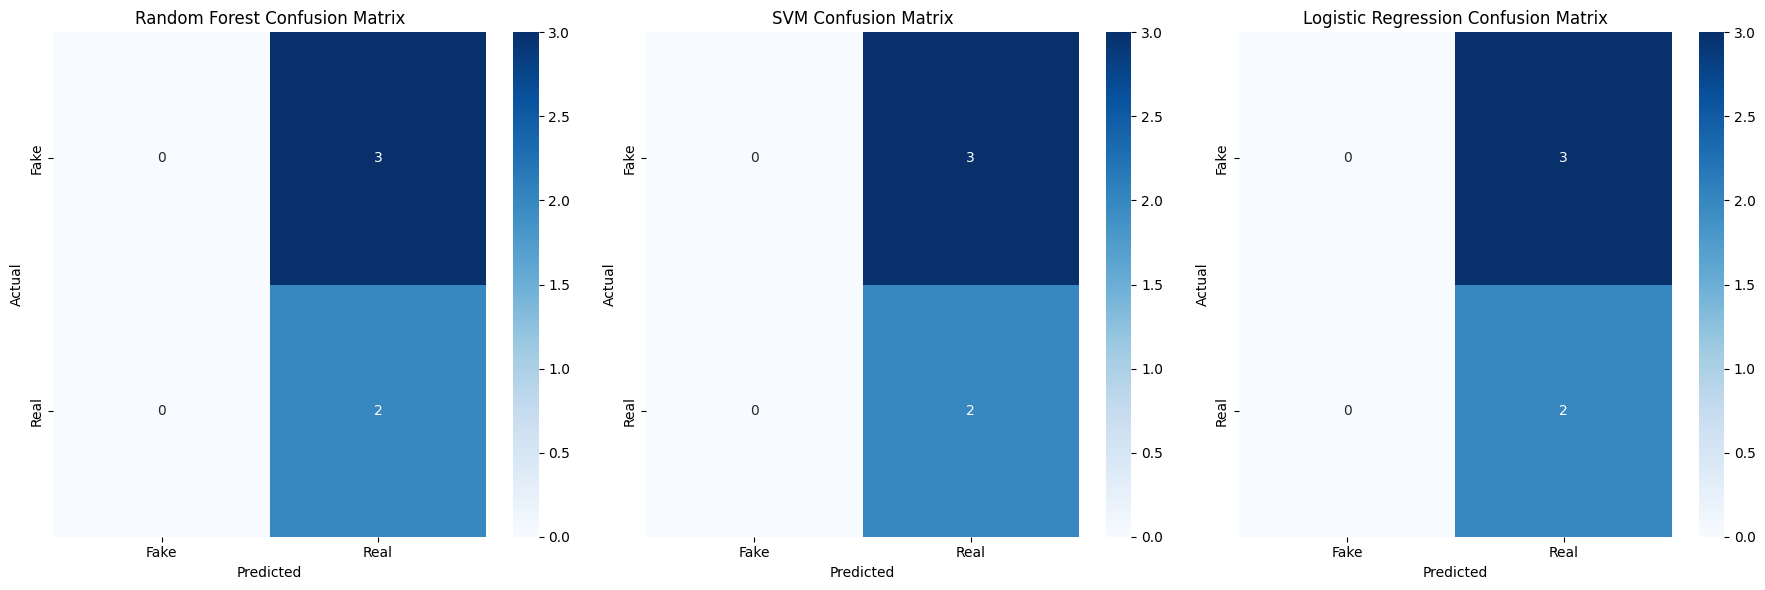

In [495]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#7.Confusion Matrix
 
#Preprocessing to headlines
df['headline'] = df['headline'].apply(preprocess_text)
 
# Vectorizing the text data
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['headline'])
y = df['label']
 
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 
# Model Defination
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42)
}
 
# Training models and generate confusion matrices
conf_matrices = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrices[name] = confusion_matrix(y_test, y_pred)
    print(f"{name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\n")
 
# Plot confusion matrices side-by-side
plt.figure(figsize=(18, 6))
for i, (name, conf_matrix) in enumerate(conf_matrices.items(), 1):
    plt.subplot(1, 3, i)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()
 

In [496]:
#8.Explainable AI (XAI) with LIME
 
# Apply preprocessing to headlines
df['headline'] = df['headline'].apply(preprocess_text)
 
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['headline'], df['label'], test_size=0.3, random_state=42)
 
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
 
# Train the best-performing model (SVM in this case)
svm_model = SVC(random_state=42, probability=True)  
svm_model.fit(X_train_vec, y_train)
 
# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=['Fake', 'Real'])
 
# Function to predict probabilities using the model
def predict_proba(texts):
    return svm_model.predict_proba(vectorizer.transform(texts))
 
# Explain a few predictions
for i in range(3):  
    text_instance = X_test.iloc[i]
    true_label = y_test.iloc[i]
    print(f"Headline: {text_instance}")
    print(f"True Label: {true_label}")
   
    # Explain the prediction
    exp = explainer.explain_instance(text_instance, predict_proba, num_features=10)
    print("Explanation:")
    print(exp.as_list())  # Print the explanation in text format
    print("\n")

Headline: police uncover alien base beneath supermarket
True Label: Fake
Explanation:
[(np.str_('police'), 0.0), (np.str_('uncover'), 0.0), (np.str_('alien'), 0.0), (np.str_('base'), 0.0), (np.str_('beneath'), 0.0), (np.str_('supermarket'), 0.0)]


Headline: moon turns green first time history
True Label: Fake
Explanation:
[(np.str_('turns'), 0.0876696774382039), (np.str_('time'), 0.060750685986315736), (np.str_('first'), 0.00498635687674292), (np.str_('green'), 0.004512150415043525), (np.str_('moon'), 0.004312113764570832), (np.str_('history'), 0.00244578090698781)]


Headline: government launches free healthcare program
True Label: Real
Explanation:
[(np.str_('government'), 0.0), (np.str_('launches'), 0.0), (np.str_('free'), 0.0), (np.str_('healthcare'), 0.0), (np.str_('program'), 0.0)]




In [497]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

#9. Ensemble Model
# Initialize the models
logistic_regression = LogisticRegression(random_state=42)
svm = SVC(probability=True, random_state=42)
random_forest = RandomForestClassifier(random_state=42)

# Create a VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('Logistic Regression', logistic_regression),
        ('SVM', svm),
        ('Random Forest', random_forest)
    ],
    voting='soft'  # Use 'soft' voting to consider predicted probabilities
)

# Train the VotingClassifier
voting_clf.fit(X_train_vec, y_train)

# Make predictions
y_pred_voting = voting_clf.predict(X_test_vec)

# Evaluate the model
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print(f"Voting Classifier Accuracy: {accuracy_voting:.4f}")
# Display the predictions and true labels
results = pd.DataFrame({'True Label': y_test, 'Predicted Label': y_pred_voting})
print(results)

# Display the accuracy
print(f"Voting Classifier Accuracy: {accuracy_voting:.4f}")

Voting Classifier Accuracy: 0.4000
   True Label Predicted Label
9        Fake            Real
11       Fake            Real
0        Real            Real
13       Fake            Real
5        Real            Real
Voting Classifier Accuracy: 0.4000


In [498]:
#10.Real-World Testing
 
df['headline'] = df['headline'].apply(preprocess_text)
 
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['headline'])
y = df['label']
 
# Train the best-performing model (SVM in this case)
svm_model = SVC(random_state=42, probability=True)
svm_model.fit(X, y)
 
# Collect real-world headlines
real_headlines = [
    "Global Climate Talks Reach Critical Agreement on Emissions Targets",  
    "Advances in AI Healthcare Lead to Breakthrough in Cancer Treatment",  
    "Renewed Space Exploration Initiatives Yield Discoveries on Mars",  
    "Geopolitical Tensions Rise as Cyber Warfare Incidents Increase",  
    "Economists predict steady growth in global markets next year"  
]
 
fake_headlines = [
    "Time Travel Discovered: Tourists Overwhelm Cretaceous Period",  
    "World Leaders Ban All Round Objects, Citing 'Existential Rolling Threat",  
    "Invisible City Discovered Beneath Pretoria, Populated Entirely by Left Socks",  
    "Plants Achieve Internet Access, Begin Writing Critical Reviews of Human Behavior",  
    "Squirrels Develop Sentience, Demand Nut-Based Representation in UN"  
]
 
# Combine real and fake headlines
test_headlines = real_headlines + fake_headlines
true_labels = ['Real'] * 5 + ['Fake'] * 5
 
test_headlines_processed = [preprocess_text(headline) for headline in test_headlines]
X_test = vectorizer.transform(test_headlines_processed)
 
# Predict using the best model
predictions = svm_model.predict(X_test)
 
# Display results
for headline, true_label, pred_label in zip(test_headlines, true_labels, predictions):
    print(f"Headline: {headline}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {pred_label}")
    print("\n")
 

Headline: Global Climate Talks Reach Critical Agreement on Emissions Targets
True Label: Real
Predicted Label: Real


Headline: Advances in AI Healthcare Lead to Breakthrough in Cancer Treatment
True Label: Real
Predicted Label: Real


Headline: Renewed Space Exploration Initiatives Yield Discoveries on Mars
True Label: Real
Predicted Label: Real


Headline: Geopolitical Tensions Rise as Cyber Warfare Incidents Increase
True Label: Real
Predicted Label: Real


Headline: Economists predict steady growth in global markets next year
True Label: Real
Predicted Label: Real


Headline: Time Travel Discovered: Tourists Overwhelm Cretaceous Period
True Label: Fake
Predicted Label: Fake


Headline: World Leaders Ban All Round Objects, Citing 'Existential Rolling Threat
True Label: Fake
Predicted Label: Real


Headline: Invisible City Discovered Beneath Pretoria, Populated Entirely by Left Socks
True Label: Fake
Predicted Label: Real


Headline: Plants Achieve Internet Access, Begin Writing Crit